In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from pipeline import AnomalyDetectionPipeline

In [13]:
data = 'data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz'

In [14]:
# Initialize Pipeline
pipeline = AnomalyDetectionPipeline(seq_length=25, batch_size=128)

Pipeline initialized on device: cuda


In [15]:
# Load Data
nrows = 50_000
pipeline.load_data(data, nrows=nrows)

Loading data from data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 50000 rows.


In [16]:
# Engineer Features
selected_features = ['base', 'tao', 'hawkes', 'poutre']
pipeline.engineer_features(feature_sets=selected_features)

Engineering features: ['base', 'tao', 'hawkes', 'poutre']...
Feature Engineering complete. Total features: 122


In [17]:
# Preprocess Data
pipeline.scale_and_sequence(method='minmax')

Preprocessing with method: minmax...
Dropping['ask-volume-10', 'ask_sweep_cost'] constant features: ['ask-volume-10', 'ask_sweep_cost']
Data split: Train (34982, 25, 120), Test (14993, 25, 120)


Initializing Transformer Autoencoder...
Training Autoencoder...
Epoch 1/2 - Loss: 0.026535
Epoch 2/2 - Loss: 0.010134
Extracting Latent Representations for OC-SVM...
Training One-Class SVM (nu=0.01)...
Evaluating model...
Calculating Feature Importance (Permutation)...


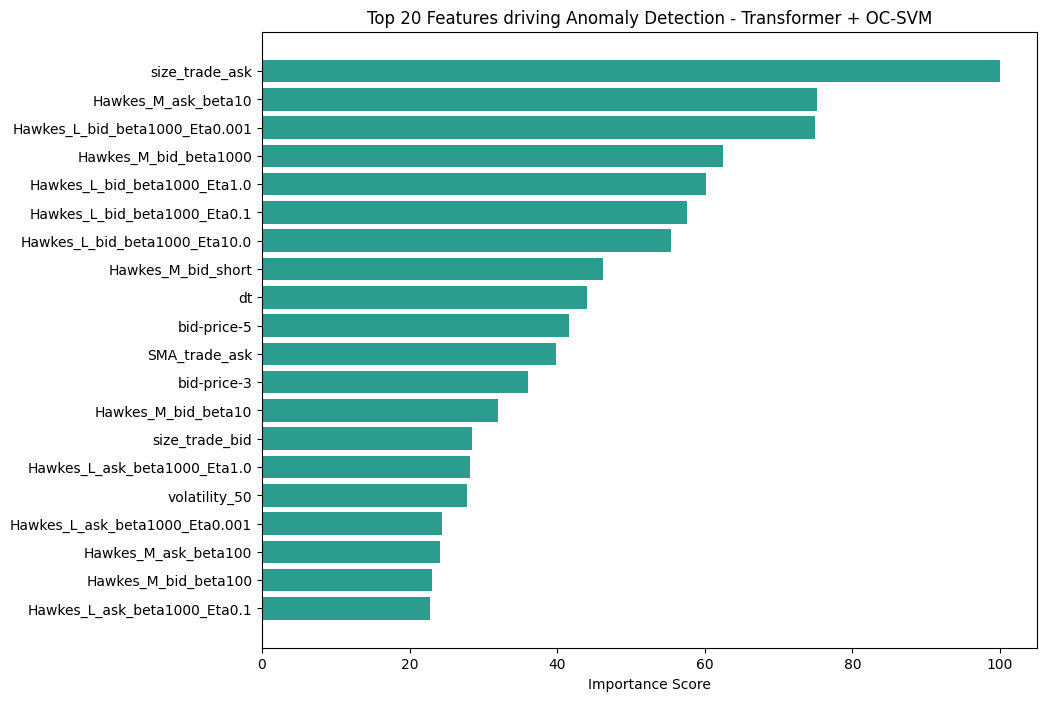

In [18]:
# Train Transformer + OC-SVM Model
pipeline.train_model(
    model_type='transformer_ocsvm', 
    epochs=2, 
    lr=1e-3,
    nu=0.01
)

# Evaluate Model
metrics_ae, cm_ae = pipeline.evaluate()

# Explainability
importance_df = pipeline.get_feature_importance(n_repeats=3)

top_20 = importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20['Feature'], top_20['Importance'], color='#2a9d8f')
plt.xlabel('Importance Score')
plt.title('Top 20 Features driving Anomaly Detection - Transformer + OC-SVM')
plt.gca().invert_yaxis()
plt.show()

Initializing Probabilistic Neural Network (PNN)...
Training PNN...
Epoch 1/2 - Loss: -0.761430
Epoch 2/2 - Loss: -1.356937
Evaluating model...
Calculating Feature Importance (Permutation)...


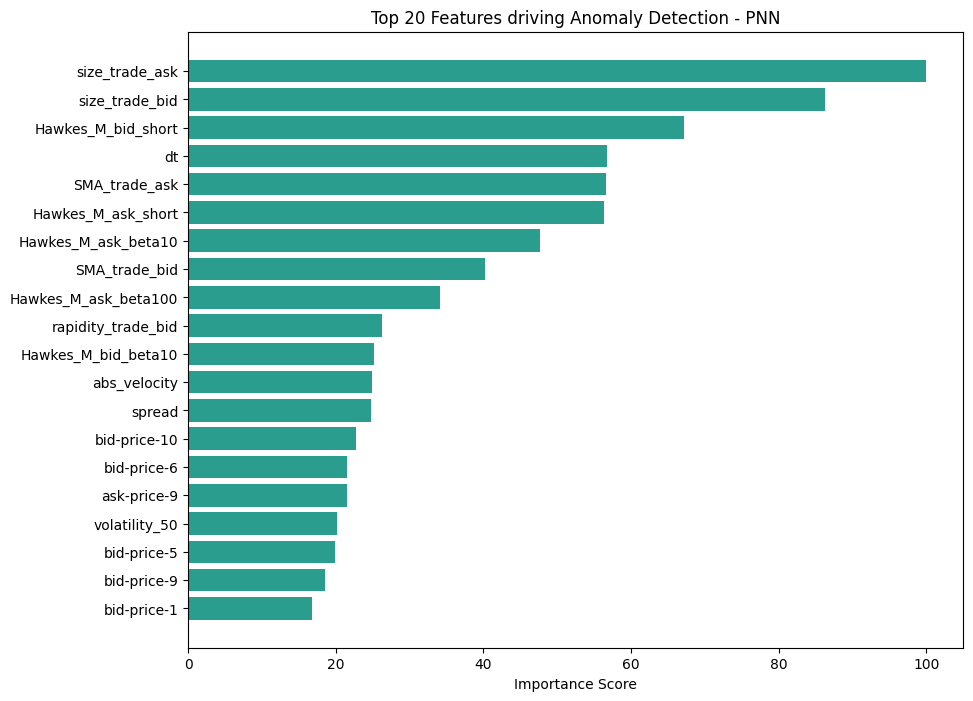

In [19]:
# Train PNN Model
pipeline.train_model(
    model_type='pnn', 
    epochs=2, 
    lr=1e-3,
    hidden_dim=64
)

metrics_pnn, cm_pnn = pipeline.evaluate()

# Explainability
importance_df = pipeline.get_feature_importance(n_repeats=3)

top_20 = importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20['Feature'], top_20['Importance'], color='#2a9d8f')
plt.xlabel('Importance Score')
plt.title('Top 20 Features driving Anomaly Detection - PNN')
plt.gca().invert_yaxis()
plt.show()

                         AUROC     AUPRC  F4_Score
Transformer + OC-SVM  1.000000  1.000000  0.999996
PNN                   0.996765  0.993572  0.998445


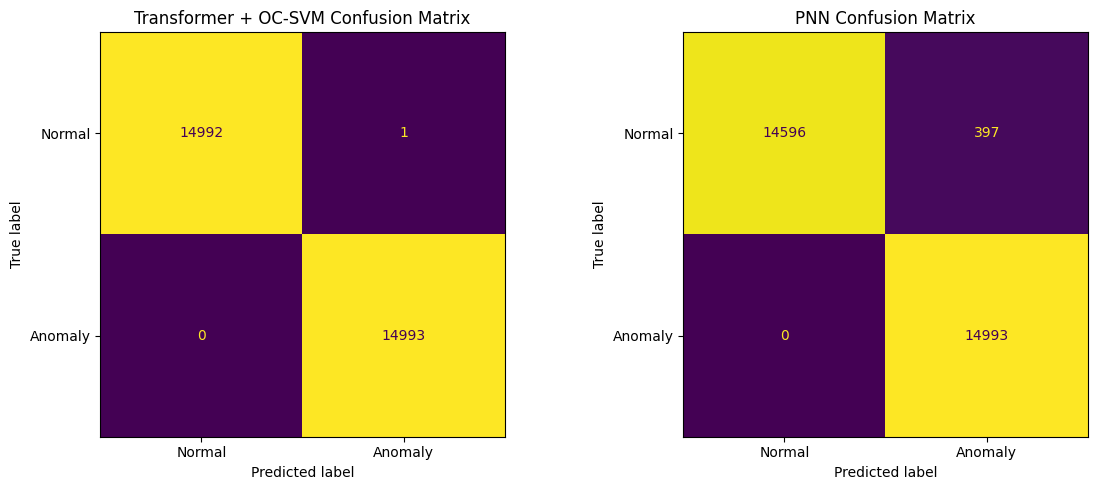

In [20]:
# Compare Results
metrics_df = pd.DataFrame([metrics_ae, metrics_pnn], index=['Transformer + OC-SVM', 'PNN'])
print(metrics_df)

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_ae, display_labels=["Normal", "Anomaly"]).plot(ax=axes[0], colorbar=False)
axes[0].set_title('Transformer + OC-SVM Confusion Matrix')

ConfusionMatrixDisplay(cm_pnn, display_labels=["Normal", "Anomaly"]).plot(ax=axes[1], colorbar=False)
axes[1].set_title('PNN Confusion Matrix')

plt.tight_layout()
plt.show()

In [21]:
# Test pipeline with Box-Cox scaler
pipeline.scale_and_sequence(method='box-cox')
pipeline.train_model(
    model_type='transformer_ocsvm', 
    epochs=2, 
    lr=1e-3,
    nu=0.01
)
metrics_boxcox, cm_boxcox = pipeline.evaluate()

Preprocessing with method: box-cox...
Data split: Train (34982, 25, 120), Test (14993, 25, 120)
Initializing Transformer Autoencoder...
Training Autoencoder...
Epoch 1/2 - Loss: 0.560101
Epoch 2/2 - Loss: 0.336028
Extracting Latent Representations for OC-SVM...
Training One-Class SVM (nu=0.01)...
Evaluating model...


         AUROC  AUPRC  F4_Score
Min-Max    1.0    1.0  0.999996
Box-Cox    1.0    1.0  0.998120


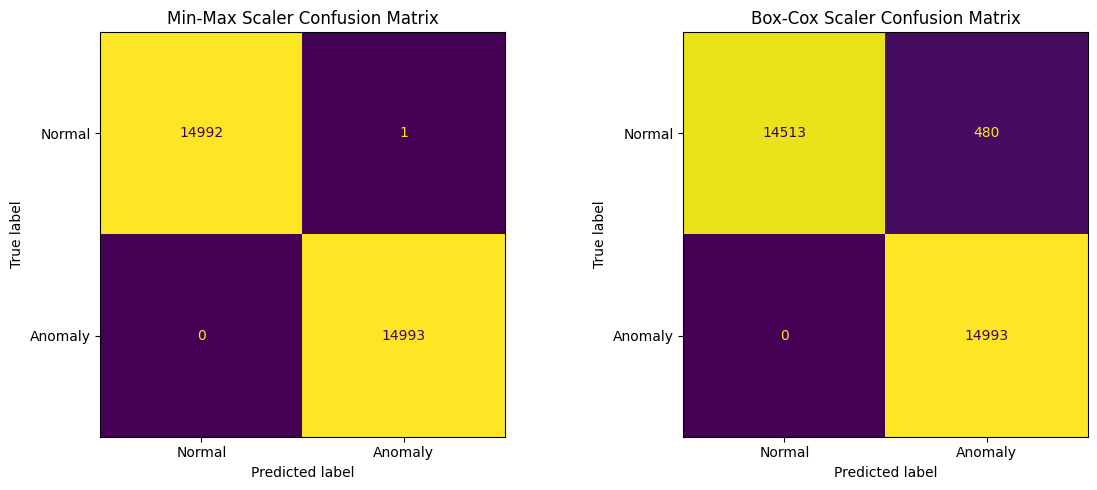

In [22]:
# Compare results with different scalers
results_df = pd.DataFrame([metrics_ae, metrics_boxcox], index=['Min-Max', 'Box-Cox'])
print(results_df)

# Plot Confusion Matrices for different scalers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_ae, display_labels=["Normal", "Anomaly"]).plot(ax=axes[0], colorbar=False)
axes[0].set_title('Min-Max Scaler Confusion Matrix')

ConfusionMatrixDisplay(cm_boxcox, display_labels=["Normal", "Anomaly"]).plot(ax=axes[1], colorbar=False)
axes[1].set_title('Box-Cox Scaler Confusion Matrix')

plt.tight_layout()
plt.show()